The goal of this notebook is to prepare a set of images of arrows for which we will apply some group transformations, more precisely, rotation, translation about the x-axis and translation about the y-axis. Then we will save the transformed arrow images as vector embedded dataset (simple embedding, only reshaping the gray scale matrix) and try to visually identify these symmetries, both through dimensionality reduction techniques and TDA. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gudhi

# Rotation of the arrow about its center

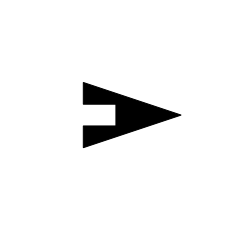

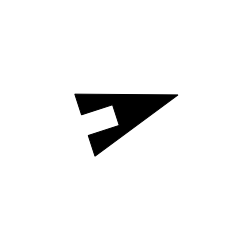

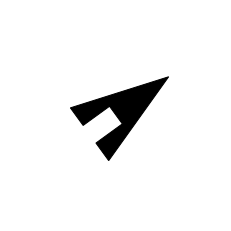

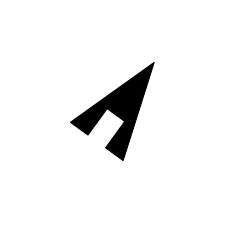

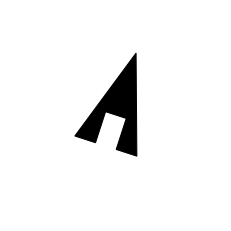

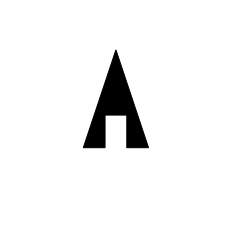

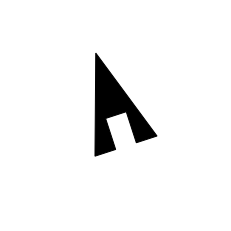

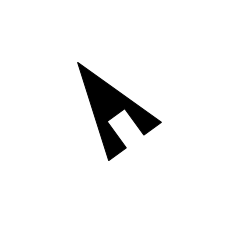

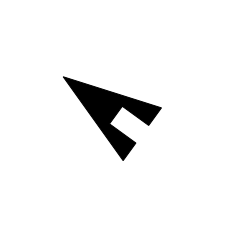

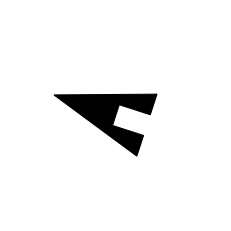

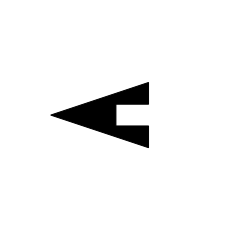

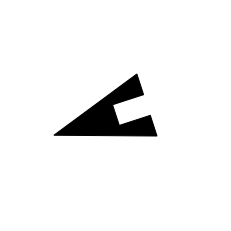

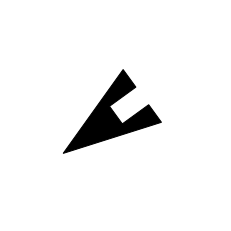

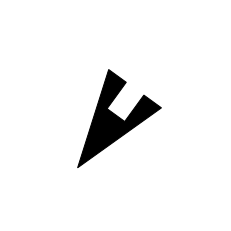

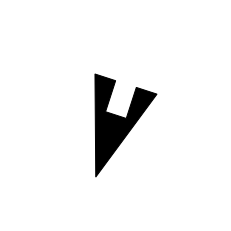

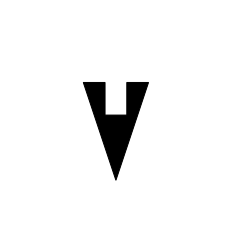

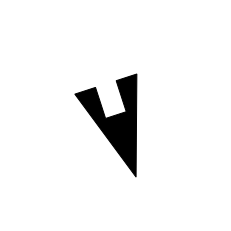

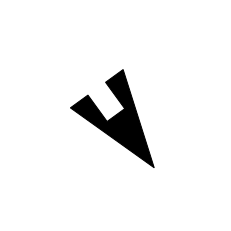

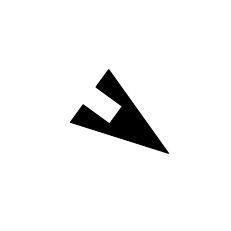

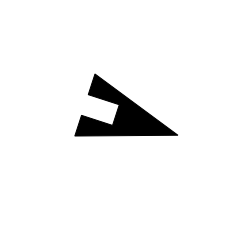

In [2]:
for value in range(0,20):
    fig, ax = plt.subplots()

    ax.arrow(0.5,0.5,0.3*np.cos(np.pi*value/10),0.3*np.sin(np.pi*value/10), width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black') #make the arrows centered at 0.5x0.5 and rotate them in a full turn in intervals
                                                # of 360/20 degrees
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.gca().set_aspect('equal', adjustable='box') #make scale of axes as similar as possible
    plt.axis('off')  
    plt.draw()

    plt.savefig('rot'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used

I performed a brute force transformation to grayscale (no need to worry about 3 channels and more complex image embedding for now, which really makes life easier). Idea on how to perform it from https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

from matplotlib.image import imread

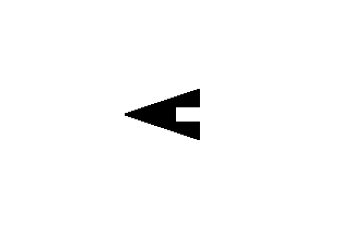

(200, 300)

In [4]:
image = imread('rot10.png')
gray = rgb2gray(image)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis('off')
plt.show()
np.shape(gray)

Let us check whether we can see an SO_2 kind structure when we look only at the rotations. For so, we might compare both PCA and ISOMAP reductions to check if we can get the desired shape.

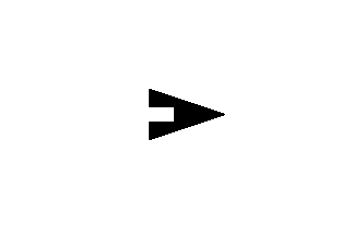

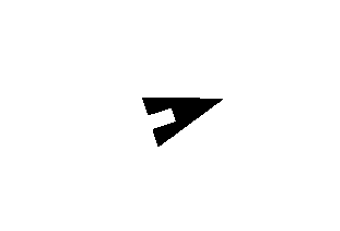

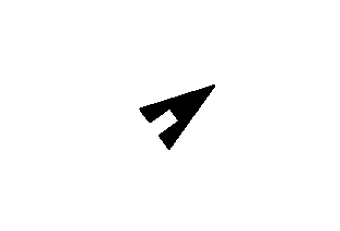

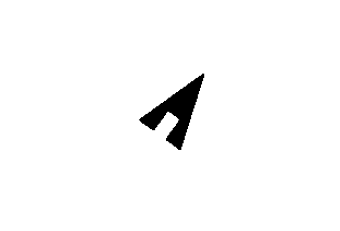

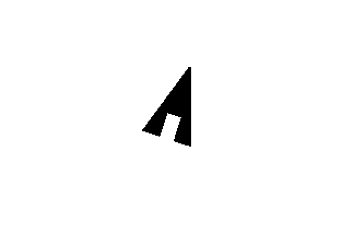

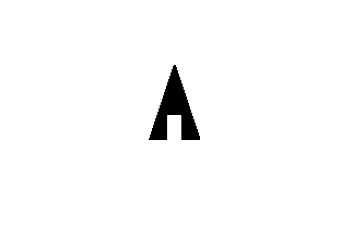

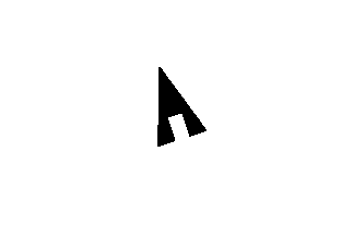

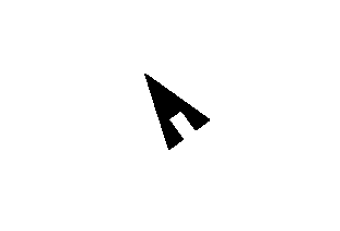

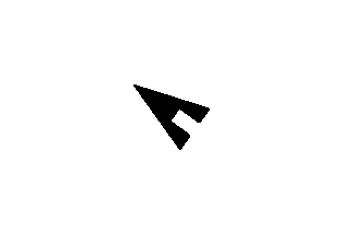

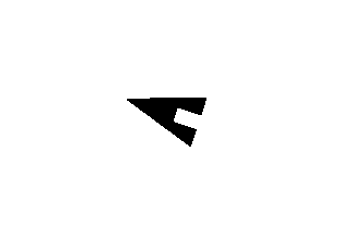

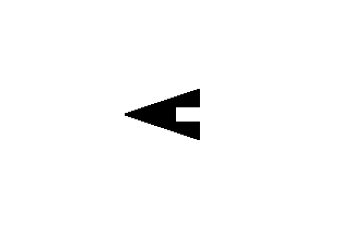

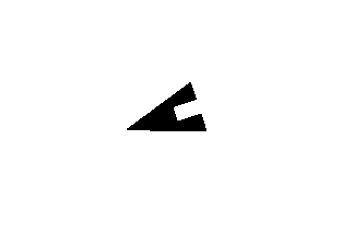

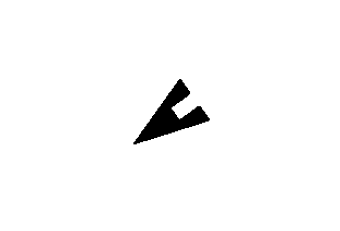

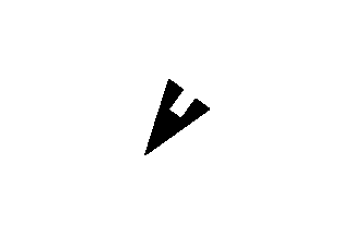

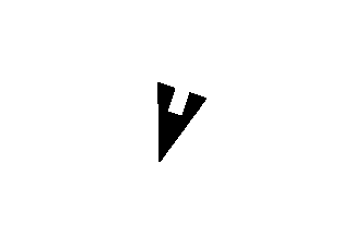

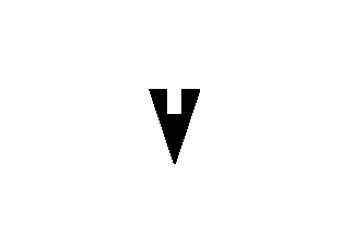

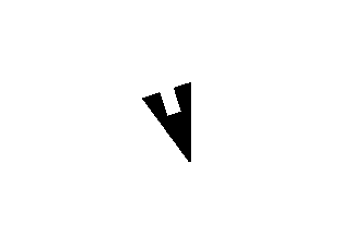

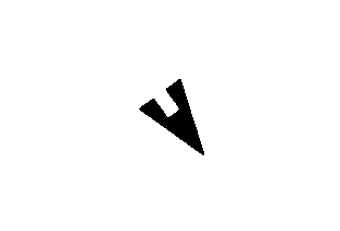

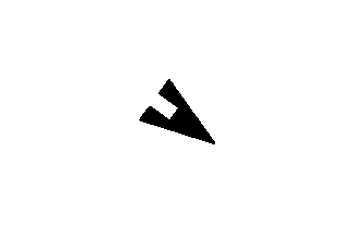

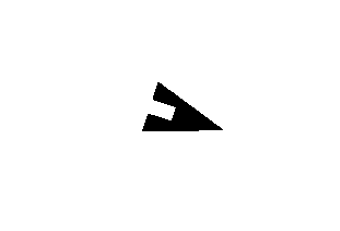

In [5]:
rot_dataset = []
for value in range(0,20):
    image = imread('rot'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    np.shape(gray)
    rot_dataset.append(gray.reshape(-1))

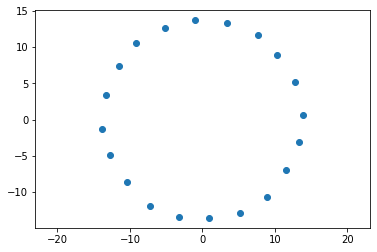

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data = pca.fit_transform(rot_dataset)
scatter = plt.scatter(data[:,0],data[:,1])
plt.axis("equal")
plt.show()

We do get exactly the SO_2 orbit action for the PCA. This means that the dataset does lie within a S_1 circle in the higher dimensional space! Let us check for ISOMAP

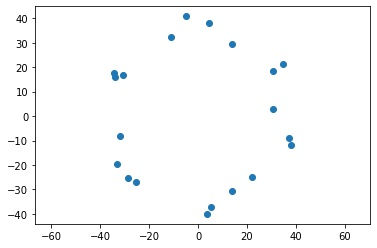

In [7]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=2)
data = embedding.fit_transform(rot_dataset)
scatter = plt.scatter(data[:,0],data[:,1])
plt.axis("equal")
plt.show()

We now get some deformation, but topologically speaking, the orbit space is exactly the same as S_1. Now, the question is: can we also see this type of structure in the original high dimension space? To probe this assumption, we can use Rips filtration to look for dim 1 cycles

usetex mode requires TeX.


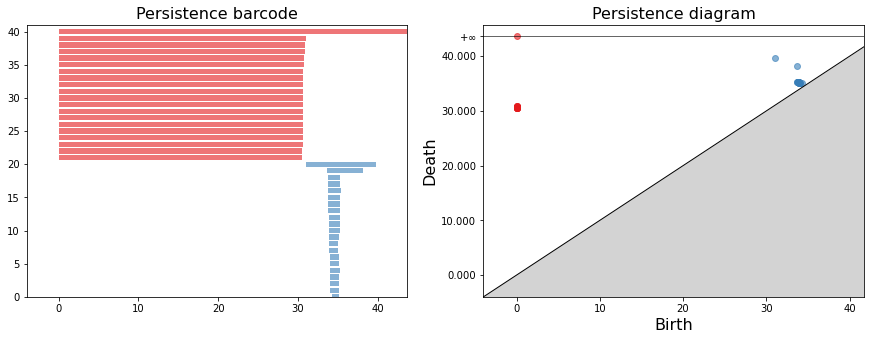

In [8]:
rips = gudhi.RipsComplex(points = rot_dataset, max_edge_length = 50)
st = rips.create_simplex_tree(max_dimension = 2)


barcodes = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)
plt.show()

There seems to be a 1-cycle of persistence barcode of (30,40), but the high dimension makes it somewhat hidden within, so the cycle is not as clear as it is in the 2 dimensional PCAed data

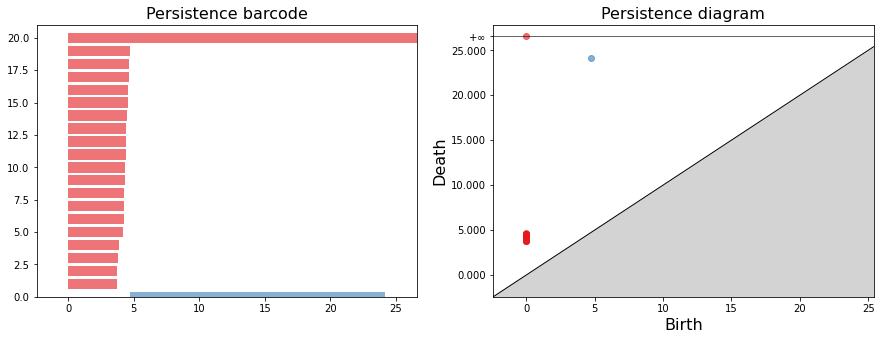

In [9]:
pca = PCA(n_components=2)
data = pca.fit_transform(rot_dataset)

rips = gudhi.RipsComplex(points = data, max_edge_length = 50)
st = rips.create_simplex_tree(max_dimension = 2)


barcodes = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)
plt.show()

The question we must look for answering is whether this "noise" is due to the embedding or simply because we are working in very high dimension and stuff is weird there.

# Two rotations


<ipython-input-10-3826336a14e2>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


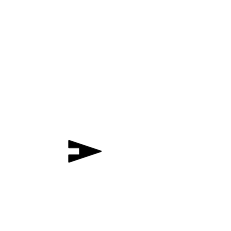

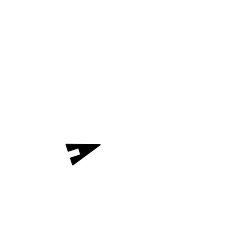

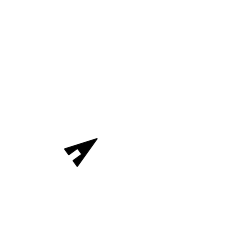

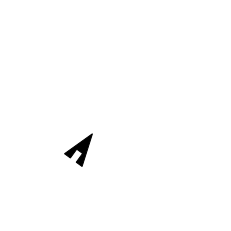

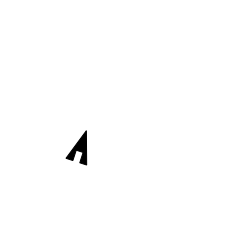

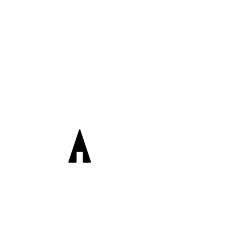

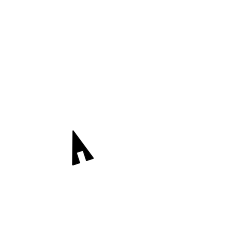

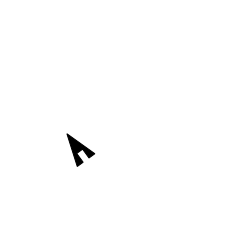

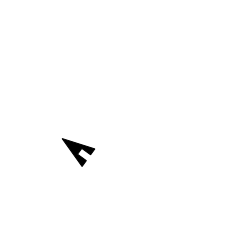

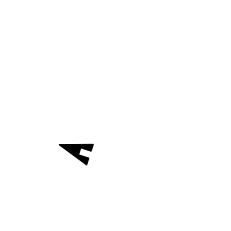

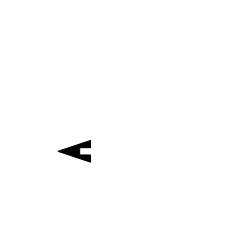

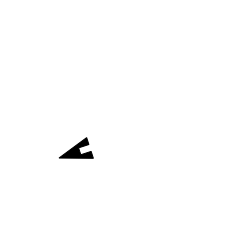

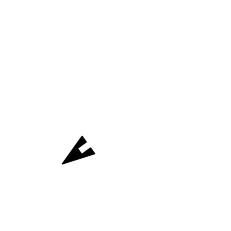

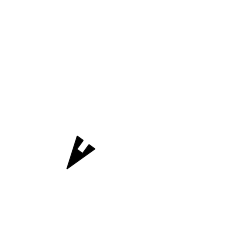

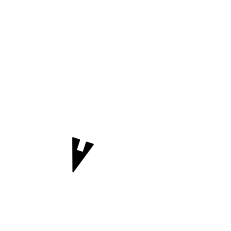

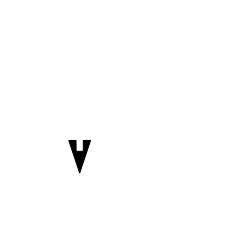

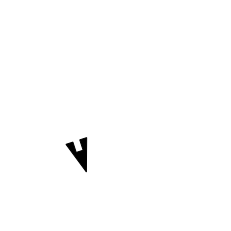

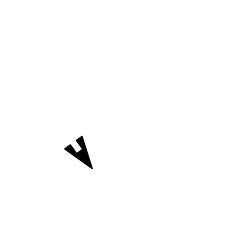

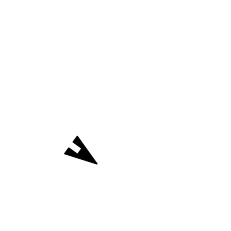

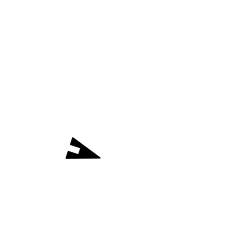

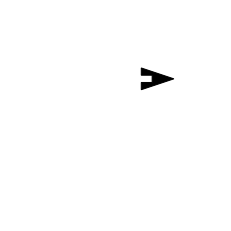

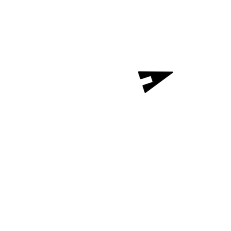

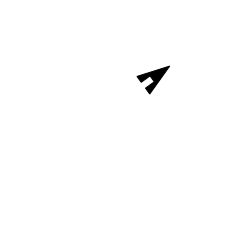

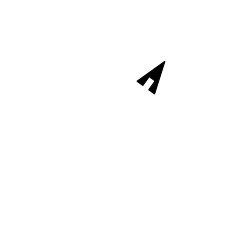

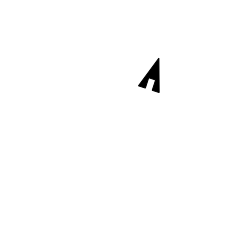

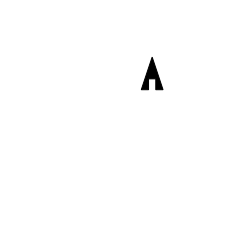

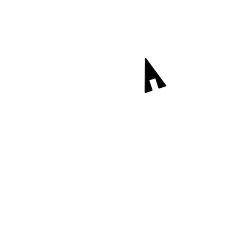

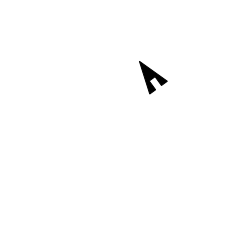

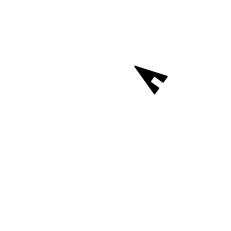

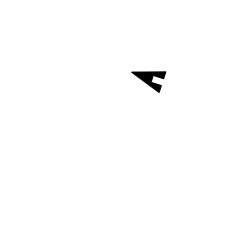

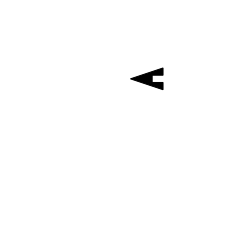

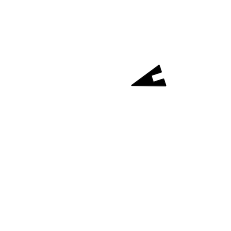

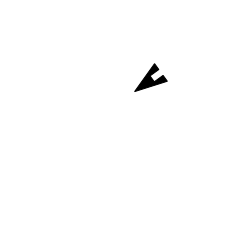

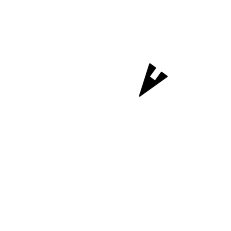

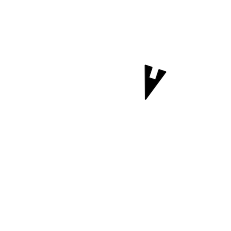

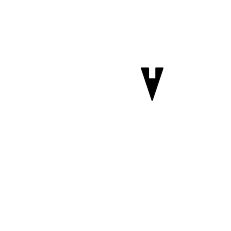

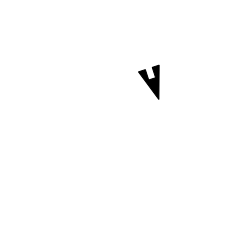

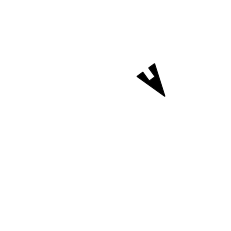

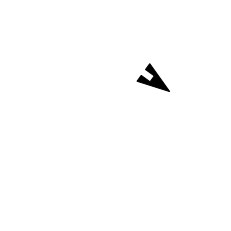

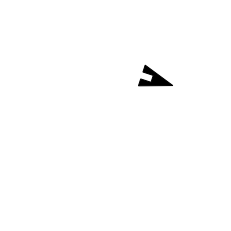

In [10]:
for value in range(0,20):
    fig, ax = plt.subplots()

    ax.arrow(1 , 1,0.3*np.cos(np.pi*value/10),0.3*np.sin(np.pi*value/10), width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black')
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    plt.gca().set_aspect('equal', adjustable='box') #make scale of axes as similar as possible
    plt.axis('off')  
    plt.draw()

    plt.savefig('two_rot_1'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used
    
for value in range(0,20):
    fig, ax = plt.subplots()

    ax.arrow(2, 2,0.3*np.cos(np.pi*value/10),0.3*np.sin(np.pi*value/10), width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black')
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])
    plt.gca().set_aspect('equal', adjustable='box') #make scale of axes as similar as possible
    plt.axis('off')  
    plt.draw()

    plt.savefig('two_rot_2'+str(value)+'.png', dpi=50) #dpi controls the number of pixels used

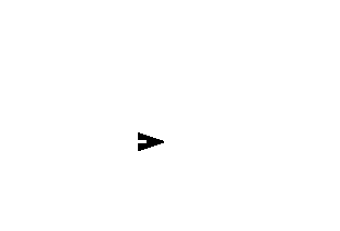

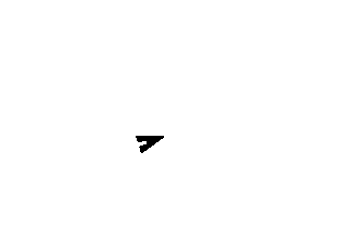

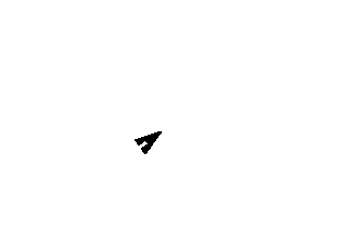

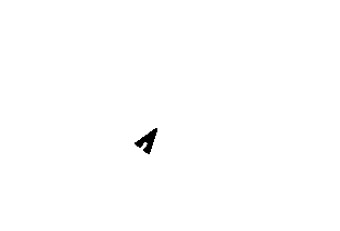

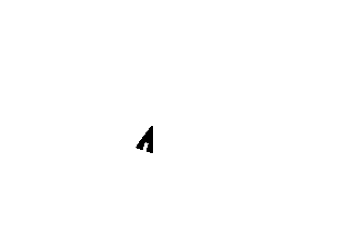

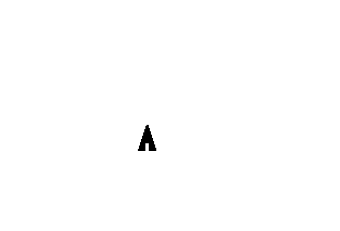

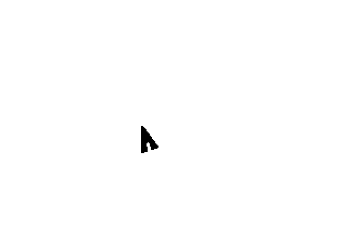

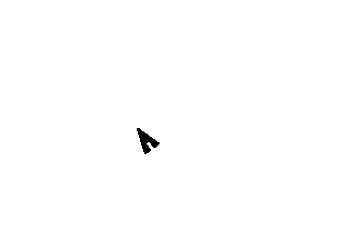

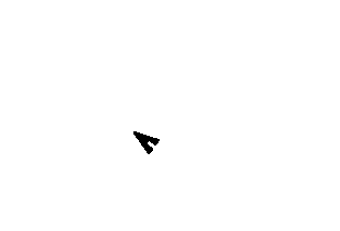

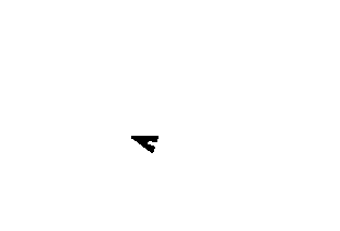

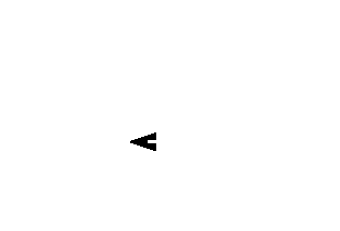

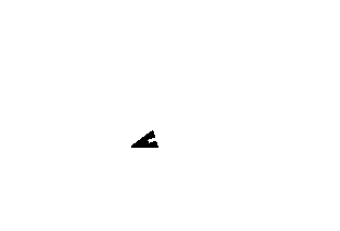

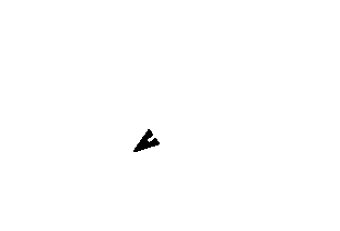

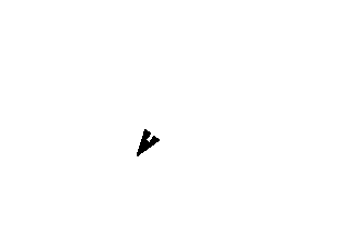

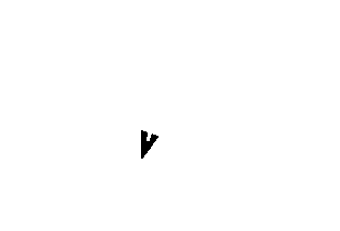

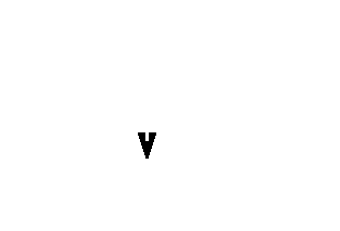

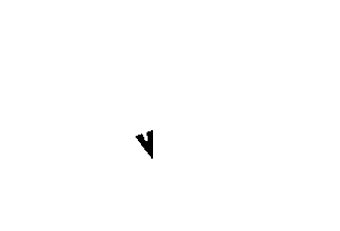

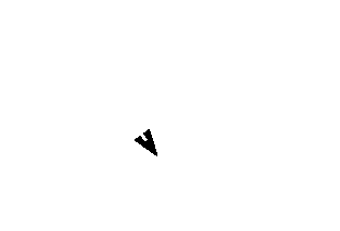

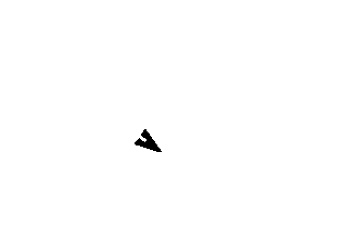

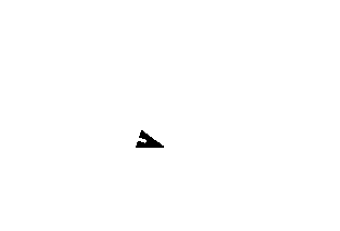

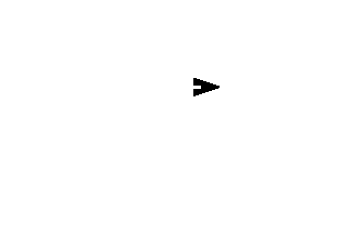

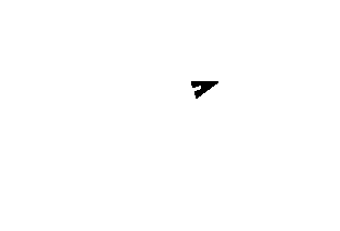

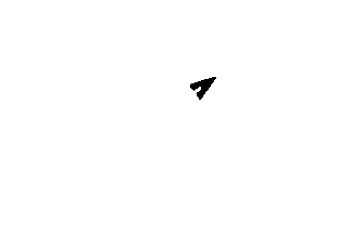

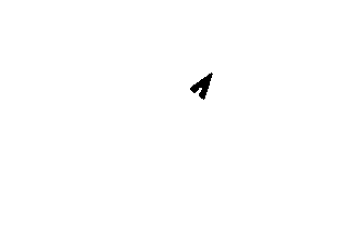

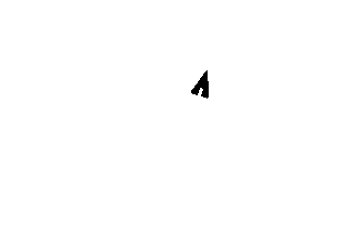

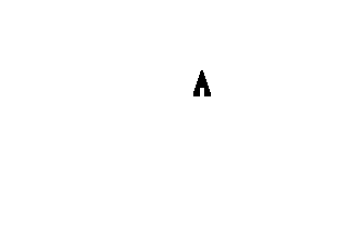

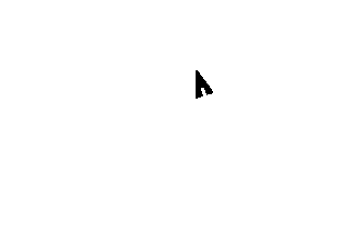

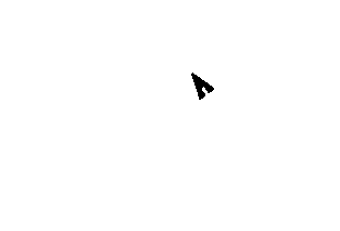

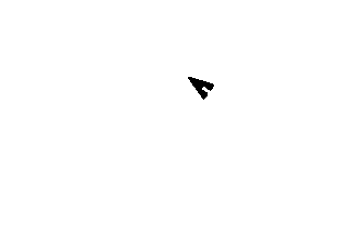

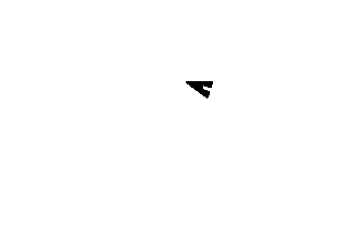

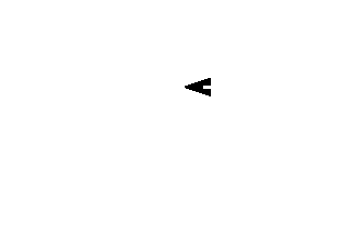

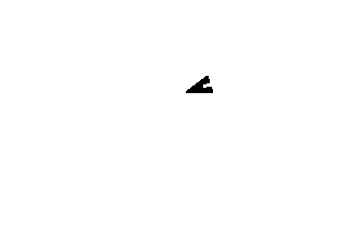

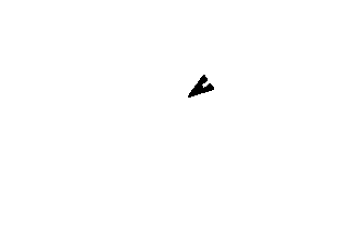

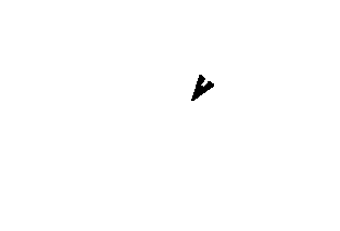

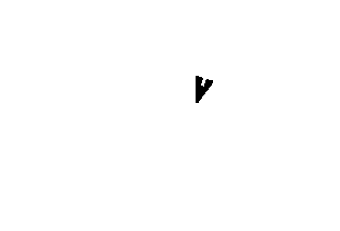

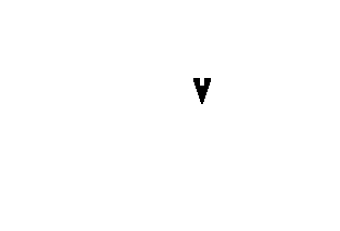

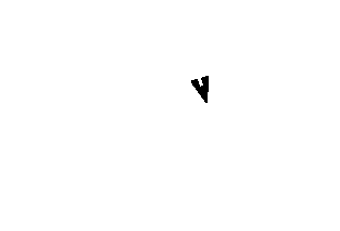

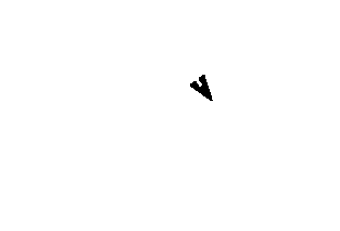

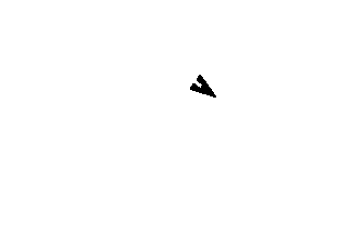

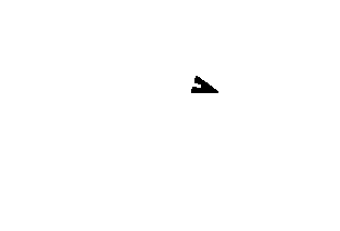

In [11]:
rot_dataset_1 = []
for value in range(0,20):
    image = imread('two_rot_1'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    np.shape(gray)
    rot_dataset_1.append(gray.reshape(-1))

label_rot_1 = []
for i in range(len(rot_dataset)):
    label_rot_1.append(0)
    
rot_dataset_2 = []
for value in range(0,20):
    image = imread('two_rot_2'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    np.shape(gray)
    rot_dataset_2.append(gray.reshape(-1))

label_rot_2 = []
for i in range(len(rot_dataset)):
    label_rot_2.append(1)

In [12]:
full_dataset = rot_dataset_1 + rot_dataset_2 
full_label = label_rot_1 + label_rot_2

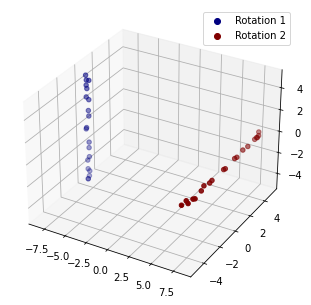

In [13]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
data = pca.fit_transform(full_dataset)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation 1', 'Rotation 2']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

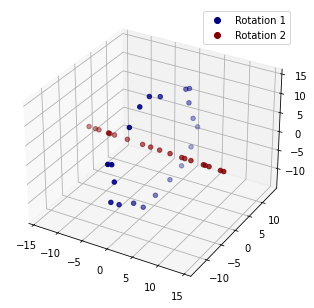

In [14]:
embedding = Isomap(n_components=3)
data = embedding.fit_transform(full_dataset)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation 1', 'Rotation 2']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

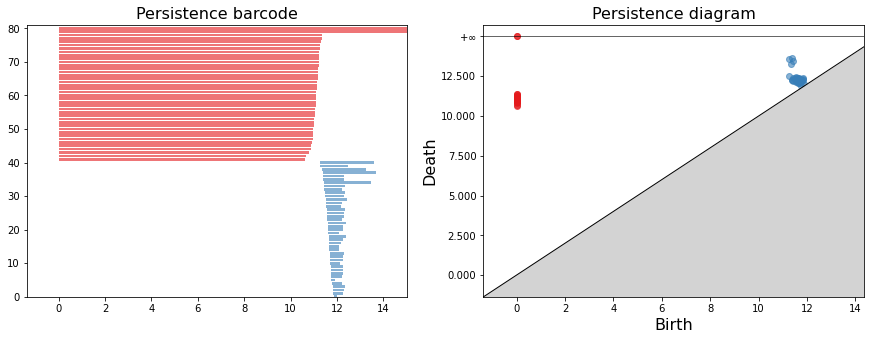

In [15]:
rips = gudhi.RipsComplex(points = full_dataset, max_edge_length = 14)
st = rips.create_simplex_tree(max_dimension = 2)


barcodes = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)

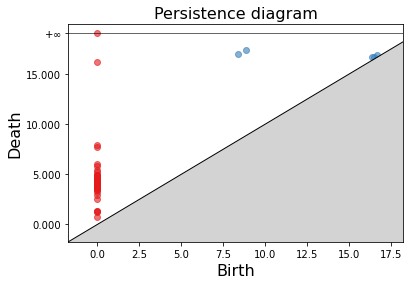

In [16]:
embedding = Isomap(n_components=4)
data = embedding.fit_transform(full_dataset)


rips = gudhi.RipsComplex(points = data, max_edge_length = 50)
st = rips.create_simplex_tree(max_dimension = 2)


barcodes = st.persistence(homology_coeff_field = 2)
gudhi.plot_persistence_diagram(barcodes)
plt.show()

# Adding translations

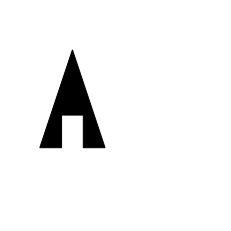

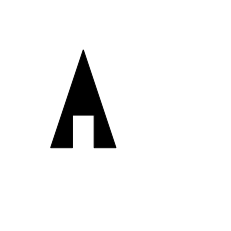

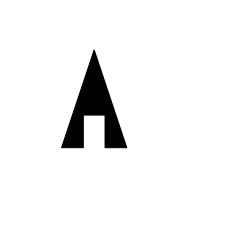

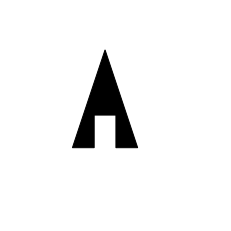

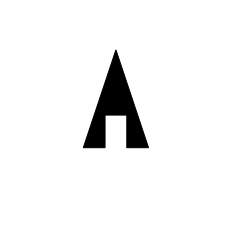

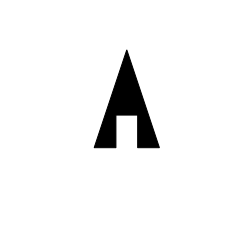

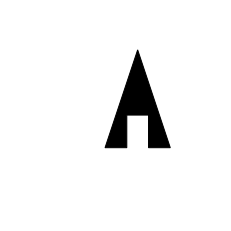

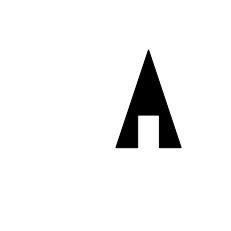

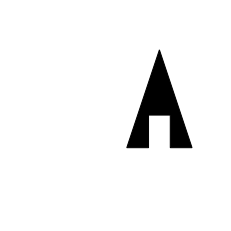

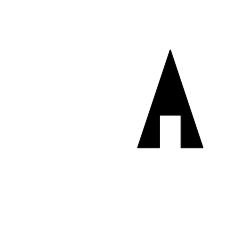

In [17]:
for value in range(0,10): 
    fig, ax = plt.subplots()

    ax.arrow(0.3+value*0.05,0.5,0,0.3, width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')  
    plt.draw()
    plt.savefig('x_trans'+str(value)+'.png', dpi=50)

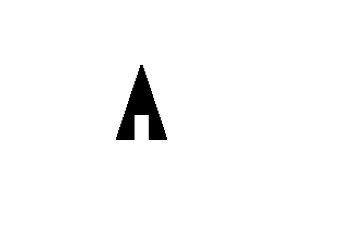

(200, 300)

In [18]:
image = imread('x_trans0.png')
gray = rgb2gray(image)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis('off')
plt.show()
np.shape(gray)

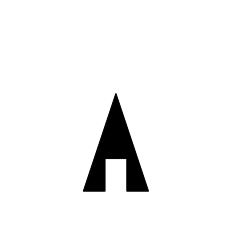

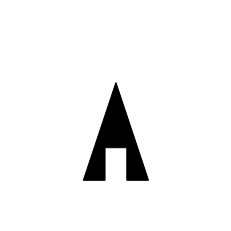

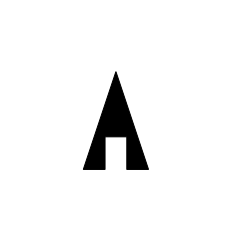

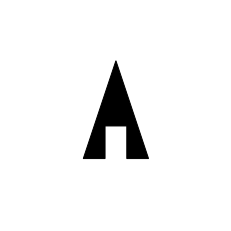

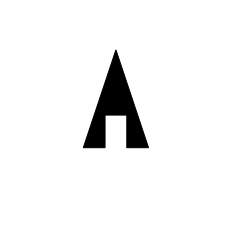

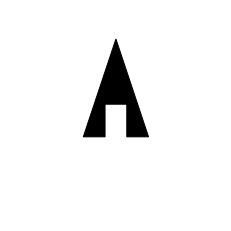

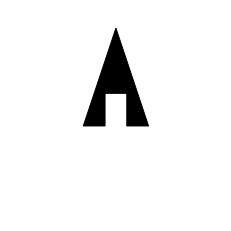

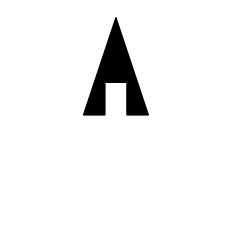

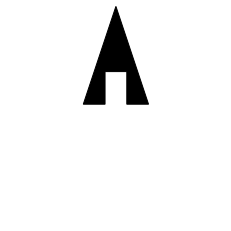

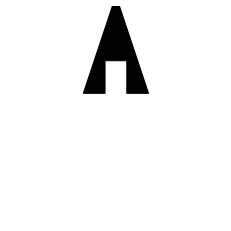

In [19]:
for value in range(0,10):    
    fig, ax = plt.subplots()

    ax.arrow(0.5,0.3+0.05*value,0,0.3, width = 0.1, length_includes_head = True, 
             head_width = 0.3, color = 'black')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')  
    plt.draw()
    plt.savefig('y_trans'+str(value)+'.png', dpi=50)

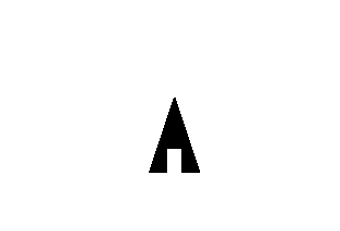

(200, 300)

In [20]:
image = imread('y_trans0.png')
gray = rgb2gray(image)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.axis('off')
plt.show()
np.shape(gray)

We make datasets of simple vectorized embedding of the images as well as label them according to the symmetry class they belong to

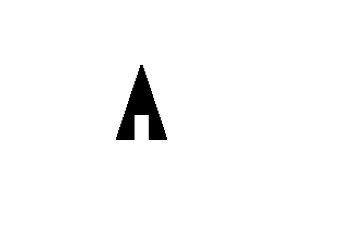

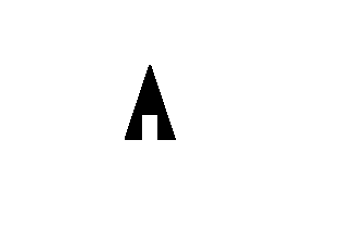

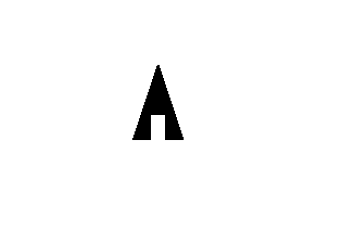

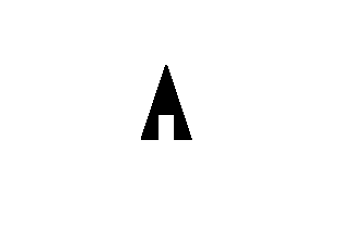

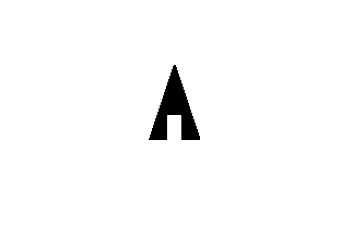

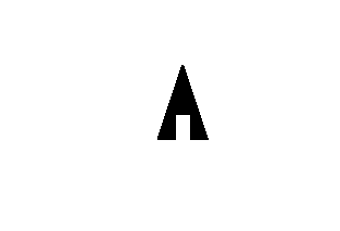

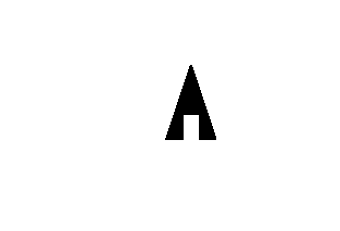

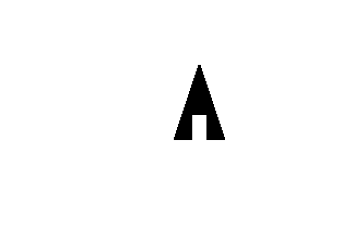

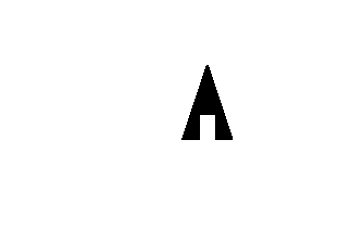

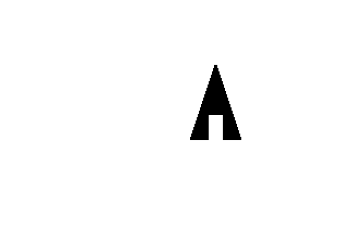

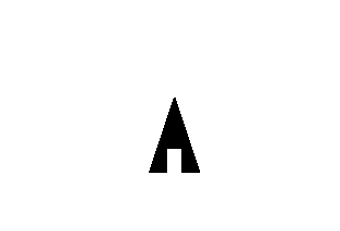

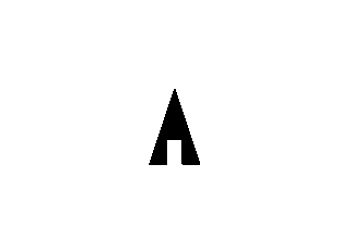

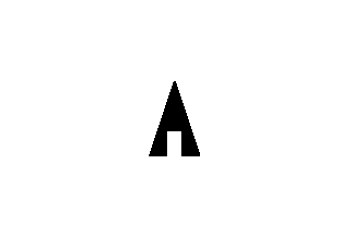

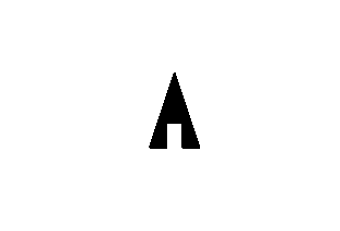

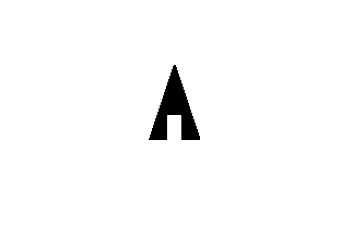

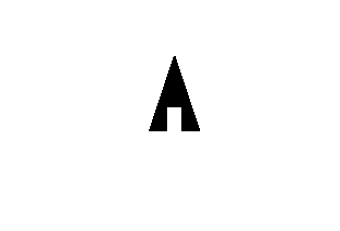

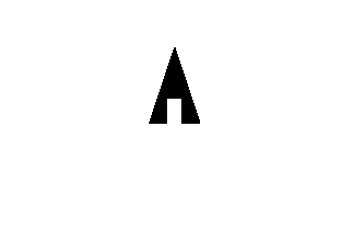

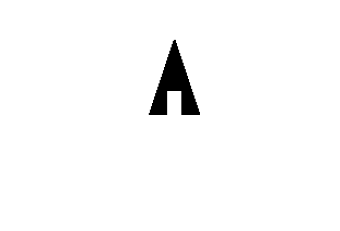

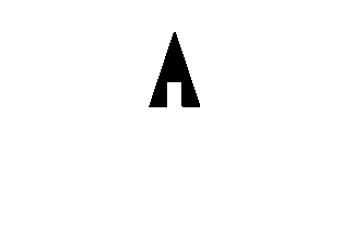

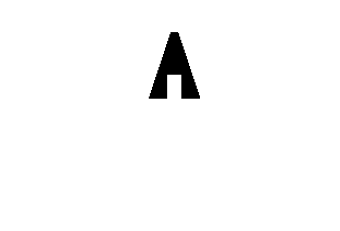

In [21]:
label_rot = []
for i in range(len(rot_dataset)):
    label_rot.append(0)
    
    
x_trans_dataset = []
for value in range(0,10):
    image = imread('x_trans'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    np.shape(gray)
    x_trans_dataset.append(gray.reshape(-1))
     
label_x_trans = []
for i in range(len(x_trans_dataset)):
    label_x_trans.append(1)   


y_trans_dataset = []
for value in range(0,10):
    image = imread('y_trans'+str(value)+'.png')
    gray = rgb2gray(image)    
    plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    np.shape(gray)
    y_trans_dataset.append(gray.reshape(-1))

label_y_trans = []
for i in range(len(y_trans_dataset)):
    label_y_trans.append(2) 

In [22]:
full_dataset = rot_dataset + x_trans_dataset + y_trans_dataset
full_label = label_rot + label_x_trans + label_y_trans

In [23]:
len(full_dataset), len(full_label)

(40, 40)

# Translation

Let us now see how translations show up. If we were to work in an infinite plane for the figures, the x-translation orbit would be a line as it represents a R symmetry. However, as our plane of work is compact, we would have to cripple image. This will make the resulting dataset look like piece of line, which may or may not have some curvature to it.

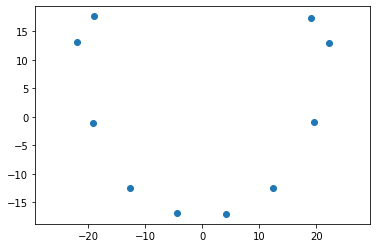

In [24]:
pca = PCA(n_components=2)
data = pca.fit_transform(x_trans_dataset)
scatter = plt.scatter(data[:,0],data[:,1])
plt.axis("equal")
plt.show()

As one can see, PCA kills the linear part expected. On the other hand, though, the symmetry about positive and negative translations is preserved, which is, in fact, an important feature of this particular Lie group. Let us see how ISOMAP behaves.

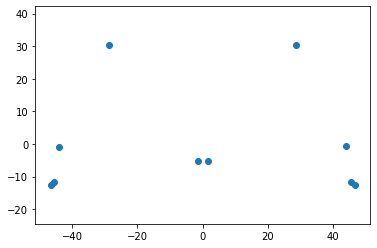

In [25]:
embedding = Isomap(n_components=2)
data = embedding.fit_transform(x_trans_dataset)
scatter = plt.scatter(data[:,0],data[:,1])
plt.axis("equal")
plt.show()

# Mix of 2 transformation

Let us now see how the dataset behaves when we have two transformations. Now, the dataset should be lie within a 2D manifold, so let us check how the dataset behaves for this 2D orbit space.

In [26]:
rot_x_data, rot_x_label = full_dataset[:-10], full_label[:-10]

In [27]:
len(rot_x_data), len(rot_x_label)

(30, 30)

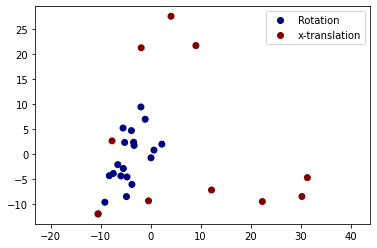

In [28]:
pca = PCA(n_components=2)
data = pca.fit_transform(rot_x_data)

classes = ['Rotation', 'x-translation']
scatter = plt.scatter(data[:,0],data[:,1], c = rot_x_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.axis("equal")
plt.show()

However, as the expected dataset is 2D, we might only see the orbit space when embedding in 3D. In fact, we expect that the dataset is something like the union of a circle and a line. Let us check if that is the case

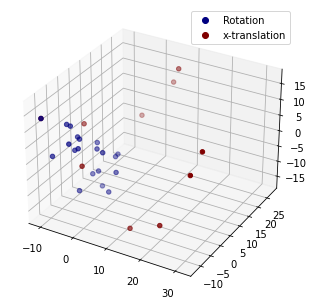

In [29]:
pca = PCA(n_components=3)
data = pca.fit_transform(rot_x_data)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation', 'x-translation']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = rot_x_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

Does not really seem like so. Therefore, when we have some other symmetries, it seems that PCA does not behave so well anymore, which makes sense, as the shape is more complex (i.e. less linear). Let us see if ISOMAP does any better

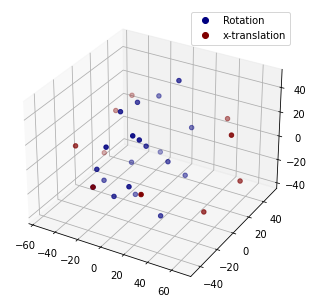

In [30]:
embedding = Isomap(n_components=3)
data = embedding.fit_transform(rot_x_data)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation', 'x-translation']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = rot_x_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

Looks a little more regular, but still not really good. 

# Mix of 3 transformation

Now let us see how the dataset behaves for 3 transformations (x,y translations and rotation). In theory, the expected shape is something like a 3 cylinder (S_1 x R x R). Let us see if that is indeed the case

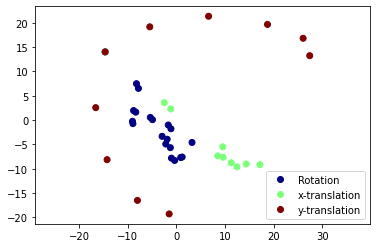

In [31]:
pca = PCA(n_components=2)
data = pca.fit_transform(full_dataset)

classes = ['Rotation', 'x-translation', 'y-translation']
scatter = plt.scatter(data[:,0],data[:,1], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.axis("equal")
plt.show()

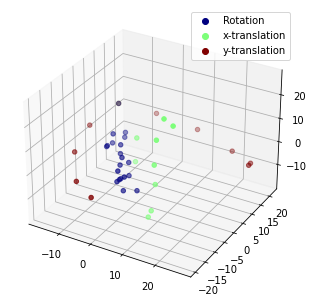

In [32]:
pca = PCA(n_components=3)
data = pca.fit_transform(full_dataset)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation', 'x-translation', 'y-translation']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

Strangely, y translation looks much more cyclic than rotation. Let us check if this is caused by PCA rather than some actually embedded information by comparing it to ISOMAP

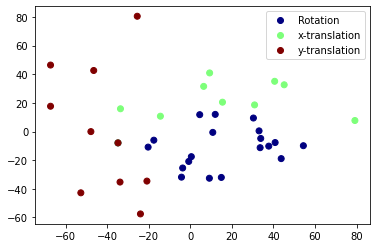

In [33]:
embedding = Isomap(n_components=2)
data = embedding.fit_transform(full_dataset)

classes = ['Rotation', 'x-translation', 'y-translation']
scatter = plt.scatter(data[:,0],data[:,1], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

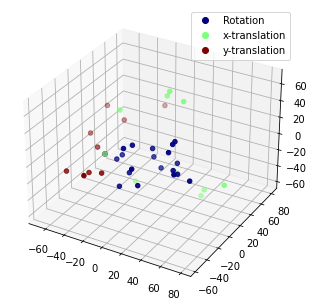

In [34]:
embedding = Isomap(n_components=3)
data = embedding.fit_transform(full_dataset)

fig = plt.figure()
ax = Axes3D(fig)

classes = ['Rotation', 'x-translation', 'y-translation']
scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c = full_label, cmap = "jet")
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()